In [1]:
import os, random
import numpy as np
import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
class PathsDataset(torch.utils.data.Dataset):
    # init the dataset, shape = L x W
    def __init__(self, gen_dir, transform=None, shape = (100,100), device='cpu', stop_after=500):
        self.device = device
        self.maps_and_paths = []

        num_maps = 0
        for directory in tqdm(os.listdir(gen_dir)):
            num_maps += 1
            dir_path = os.path.join(gen_dir, directory)
            sequence = []

            # open map file:
            with open(f"{dir_path}/{directory}.txt", 'r') as f:
                self.flat_map = np.loadtxt(f)
                self.map = np.asarray(self.flat_map, dtype=np.float32).reshape(shape[0],shape[1])

            # add map to sequence array:
            sequence.append(torch.tensor(self.map))

            path_dir = f"{dir_path}/paths/"
            num_paths = 0
            for filename in os.listdir(path_dir):
                num_paths += 1
                with open(os.path.join(path_dir, filename), 'r') as f: # open in readonly mode
                    path_points_list = [] # a list to hold each point in a path
                    self.flat_path = np.loadtxt(f) # load in the flat path from file
                    self.path = np.asarray(self.flat_path, dtype=np.float32).reshape(len(self.flat_path)//2,2) #unflatten the path from the file
                    for point in self.path:
                        x = point[0]
                        y = point[1]
                        this_point = [x, y]
                        path_points_list.append(this_point)
                # sequence = []
                # sequence.append(torch.tensor(self.map))
                sequence.append(torch.tensor(path_points_list, dtype=torch.float)[:, :])
                
            self.maps_and_paths.append(sequence)

            if num_maps == stop_after:
                break
        
        self.transform = transform
        print("Done!")

    def convert_path(self, map_dim, path):
        path_mat = np.zeros(map_dim, dtype=float)

        # Make the path continuous
        for i in range(path.shape[0] - 1):
            x = path[i,0]
            x1 = path[i,0]
            x2 = path[i+1,0]

            y = path[i,1]
            y1 = path[i,1]
            y2 = path[i+1,1]

            if (x1 < x2):
                x_dir = 1
            else:
                x_dir = -1

            if (y1 < y2):
                y_dir = 1
            else:
                y_dir = -1

            # Determine y from x
            if x2-x1 != 0:
                m = (y2-y1)/(x2-x1)
                while x != x2:
                    y = round(m*(x-x1) + y1)
                    path_mat[y,x] = 1
                    x += x_dir
            else:
                while x != x2:
                    path_mat[y1,x] = 1
                    x += x_dir


            x = path[i,0]
            x1 = path[i,0]
            x2 = path[i+1,0]

            y = path[i,1]
            y1 = path[i,1]
            y2 = path[i+1,1]

            # Determine x from y
            if y2-y1 != 0:
                m = (x2-x1)/(y2-y1)
                while y != y2:
                    x = round(m*(y-y1) + x1)
                    path_mat[y,x] = 1
                    y += y_dir
            else:
                while y != y2:
                    path_mat[y,x1] = 1
                    y += y_dir

        return path

    def __len__(self):
        return len(self.maps_and_paths)

    def __getitem__(self, idx):
        x = self.maps_and_paths[idx]
        if self.transform:
            x = self.transform(x)
        
        return x

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# dataset name
MAP_NAME = '8x12_map_cropped'
DATASET = 'train'
MAP_SHAPE = (64,64)
# loading info
ENCODER_PATH = f"checkpoints/encoder/"
DECODER_PATH = f"checkpoints/decoder/"
LOAD_EPOCH = 149
# training parameters
BATCH_SIZE = 1
train_dataset = PathsDataset(gen_dir = f"./env/many_maps_1/{DATASET}/", shape = MAP_SHAPE, transform=None, device=device, stop_after=6000)
dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

100%|██████████| 5999/5999 [00:28<00:00, 211.36it/s]

Done!


In [4]:
class Encoder(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        ### Convolutional section
        self.encoder_cnn = nn.Sequential(
            nn.Conv2d(1, 16, 5, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.Conv2d(16, 32, 5, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            nn.Conv2d(32, 64, 5, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),     
            nn.Conv2d(64, 128, 7, stride=2, padding=0),
            nn.BatchNorm2d(128),
            nn.ReLU(True),  
        )
        
        ### Flatten layer
        self.flatten = nn.Flatten(start_dim=1)
        
    def forward(self, x):
        x = self.encoder_cnn(x)
        x = self.flatten(x)
        return x

In [5]:
# class Decoder(nn.Module):
    
#     def __init__(self):
#         super().__init__()

#         self.unflatten = nn.Unflatten(dim=1, 
#         unflattened_size=(128, 1, 1))

#         self.decoder_conv = nn.Sequential(
#             nn.ConvTranspose2d(128, 64, 7, 
#             stride=2, padding=0, output_padding=0),
#             nn.BatchNorm2d(64),
#             nn.ReLU(True),
#             nn.ConvTranspose2d(64, 32, 5,
#             stride=2, padding=1, output_padding=0),
#             nn.BatchNorm2d(32),
#             nn.ConvTranspose2d(32, 16, 5, 
#             stride=2, padding=1, output_padding=0),
#             nn.BatchNorm2d(16),
#             nn.ReLU(True),
#             nn.ConvTranspose2d(16, 1, 5, 
#             stride=2, padding=1, output_padding=1)
#         )
        
#     def forward(self, x):
#         x = self.unflatten(x)
#         x = self.decoder_conv(x)
#         x = torch.sigmoid(x)
#         return x

In [6]:
# create a new encoder
encoder = Encoder()
# decoder = Decoder()

In [7]:
#todo: load encoder checkpoint from file
checkpoint = torch.load(f'{ENCODER_PATH}epoch-{LOAD_EPOCH}.tar')
encoder.load_state_dict(checkpoint['model_state_dict'])

# checkpoint = torch.load(f'{DECODER_PATH}epoch-{LOAD_EPOCH}.tar')
# decoder.load_state_dict(checkpoint['model_state_dict'])

encoder.to(device)
# decoder.to(device)

encoder.eval()
# decoder.eval()

Encoder(
  (encoder_cnn): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(16, 32, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv2d(32, 64, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): Conv2d(64, 128, kernel_size=(7, 7), stride=(2, 2))
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
)

In [8]:
# #todo: run the map through the encoder and get an encoded map to use in the lstm
# flat_map = np.loadtxt(f"./env/{MAP_NAME}/{MAP_NAME}.txt", skiprows=2)                                                   # load in the flat path from file
# map = torch.tensor(np.asarray(flat_map, dtype=int).reshape(MAP_SHAPE[0], MAP_SHAPE[1])).to(device, dtype=torch.float)     # unflatten the map from the file

# # plt.imshow(map.cpu())
# # plt.show()

# map_4d = map.unsqueeze(0).unsqueeze(0)
# encoded_map = encoder(map_4d)#.squeeze()
# # print(encoded_map.shape)

# # decoded_map = decoder(encoded_map)
# # new_map_2d = decoded_map.squeeze()

# # plt.imshow(new_map_2d.cpu().detach().numpy())
# # plt.show()

In [9]:
maps = []

train_target_paths = []
train_input_paths = []
train_goal_points = []

test_target_paths = []
test_input_paths = []
test_goal_points = []

nbr_eval_paths = 2

for data in train_dataset:
    maps.append(data[0].to(device))

    train_target_paths_dummy = []
    train_input_paths_dummy = []
    train_goal_points_dummy = torch.Tensor()

    test_target_paths_dummy = []
    test_input_paths_dummy = []
    test_goal_points_dummy = torch.Tensor()

    for path in data[nbr_eval_paths+1:]:
        input_path = path[:-1] #all points execpt last
        target_path = path[1:]
        goal_point = path[len(path)-1].unsqueeze(0)

        train_target_paths_dummy.append(torch.Tensor(target_path).to(device))
        train_input_paths_dummy.append(torch.Tensor(input_path).to(device))
        train_goal_points_dummy = torch.cat((train_goal_points_dummy, goal_point), 0)

    for path in data[1:nbr_eval_paths+1]:
        input_path = path[:-1] #all points execpt last five
        target_path = path[1:]
        goal_point = path[len(path)-1].unsqueeze(0)

        test_target_paths_dummy.append(torch.Tensor(target_path).to(device))
        test_input_paths_dummy.append(torch.Tensor(input_path).to(device))
        test_goal_points_dummy = torch.cat((test_goal_points_dummy, goal_point), 0)

    train_goal_points_dummy = train_goal_points_dummy.to(device)
    test_goal_points_dummy = test_goal_points_dummy.to(device)

    # add paths
    train_target_paths.append(train_target_paths_dummy)
    train_input_paths.append(train_input_paths_dummy)
    train_goal_points.append(train_goal_points_dummy)

    test_target_paths.append(test_target_paths_dummy)
    test_input_paths.append(test_input_paths_dummy)
    test_goal_points.append(test_goal_points_dummy)



In [10]:
print(len(train_input_paths))
print(len(train_target_paths))
print(len(train_goal_points))

print(len(test_input_paths))

map_num = 1

print(f"path num: {len(train_input_paths[map_num])}")
print(train_input_paths[map_num])
print(len(train_target_paths[map_num]))
print(len(train_goal_points[map_num]))

5999
5999
5999
5999
path num: 8
[tensor([[52., 46.],
        [49., 42.],
        [46., 39.],
        [44., 36.],
        [41., 33.],
        [38., 30.],
        [36., 27.]], device='cuda:0'), tensor([[26., 17.],
        [23., 20.],
        [26., 23.],
        [29., 25.],
        [33., 25.],
        [37., 27.],
        [37., 31.],
        [39., 35.],
        [40., 39.],
        [38., 42.],
        [39., 46.],
        [35., 48.],
        [31., 48.],
        [27., 48.],
        [23., 49.],
        [20., 47.],
        [16., 46.],
        [13., 44.],
        [10., 46.],
        [ 7., 49.],
        [ 4., 52.]], device='cuda:0'), tensor([[40.,  3.],
        [36.,  5.]], device='cuda:0'), tensor([[32., 31.],
        [31., 27.],
        [27., 28.],
        [24., 27.],
        [20., 24.],
        [17., 27.],
        [14., 26.],
        [12., 30.],
        [11., 33.],
        [10., 37.]], device='cuda:0'), tensor([[52., 45.],
        [48., 42.],
        [45., 40.],
        [42., 37.]], device='cu

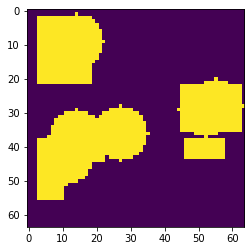

torch.Size([1, 128])


In [11]:
map = maps[0]
# print(map.device)
plt.imshow(map.cpu())
plt.show()

map_4d = map.unsqueeze(0).unsqueeze(0)
encoded_map = encoder(map_4d)#.squeeze()
print(encoded_map.shape)

# decoded_map = decoder(encoded_map)
# new_map_2d = decoded_map.squeeze()

# plt.imshow(new_map_2d.cpu().detach().numpy())
# plt.show()

In [12]:
class MyLSTM(nn.Module):
  # hidden_d - the size of the hidden LSTM layers
  # map_d - the flattened/encoded map dimension
  def __init__(self, hidden_d=120, map_d=128, device="cpu"):
    self.hidden_d = hidden_d
    self.device = device
    super(MyLSTM, self).__init__()

    # map hidden layer
    self.lstm_map = nn.LSTMCell(input_size=map_d, hidden_size=self.hidden_d, device=self.device)

    # points hidden layer
    self.lstm_points = nn.LSTMCell(input_size=4, hidden_size=self.hidden_d, device=self.device)
    
    # "upper" hidden layer
    self.lstm1 = nn.LSTMCell(input_size=self.hidden_d*2, hidden_size=self.hidden_d, device=self.device)
    self.fc = nn.Linear(self.hidden_d, 2, device=self.device)


  def forward(self, goal_point, current_point, map):

    # Creation of cell state and hidden state for map hidden layer
    hidden_state_map = torch.zeros(1, self.hidden_d).to(self.device)
    cell_state_map = torch.zeros(1, self.hidden_d).to(self.device)

    # Creation of cell state and hidden state for points hidden layer
    hidden_state_points = torch.zeros(1, self.hidden_d).to(self.device)
    cell_state_points = torch.zeros(1, self.hidden_d).to(self.device)

    # Creation of cell state and hidden state for "upper" hidden layer
    hidden_state_1 = torch.zeros(1, self.hidden_d).to(self.device)
    cell_state_1 = torch.zeros(1, self.hidden_d).to(self.device)

    outputs = []

    # initialize weights to random[-0.1, 0.1) (need to update initialzation to match paper)
    # weights initialization
    torch.nn.init.xavier_normal_(hidden_state_map)
    torch.nn.init.xavier_normal_(cell_state_map)

    torch.nn.init.xavier_normal_(hidden_state_points)
    torch.nn.init.xavier_normal_(cell_state_points)

    torch.nn.init.xavier_normal_(hidden_state_1)
    torch.nn.init.xavier_normal_(cell_state_1)

    # Concatenate start and goal
    points = torch.cat([current_point, goal_point], 0).unsqueeze(0)

    hidden_state_map, cell_state_map = self.lstm_map(map, (hidden_state_map, cell_state_map))
    hidden_state_points, cell_state_points = self.lstm_points(points, (hidden_state_points, cell_state_points))

    # Concatenate the output the lstm layer output from points and map into a single input to the final "upper" hidden layer
    final_layer_input = torch.cat([hidden_state_map, hidden_state_points], 1)
    hidden_state_1, cell_state_1 = self.lstm1(final_layer_input, (hidden_state_1, cell_state_1))
      
    # Last hidden state is passed through a fully connected neural net
    output = self.fc(hidden_state_1)	
    outputs.append(output)

    outputs = torch.cat(outputs, dim=0)
    
    return outputs

  0%|          | 0/4 [00:00<?, ?it/s]

epoch: 0
1925.1640625
2651.432861328125
1323.885986328125
1.1261309385299683
2041.638916015625
45.4398307800293
206.80001831054688
1246.8681640625
2557.973388671875
2449.259521484375
85.72711944580078
2115.45703125
1882.8310546875
542.2778930664062
415.0906982421875
1381.90673828125
338.49786376953125
901.7596435546875
1498.57080078125
1168.81298828125
486.72161865234375
189.76736450195312
1315.414794921875
894.80810546875
84.73872375488281
220.13107299804688
43.89070510864258
110.62377166748047
1738.487060546875
2537.45556640625
1047.2354736328125
1206.849609375
1214.5516357421875
576.093017578125
314.0319519042969
218.57269287109375
995.75244140625
245.33987426757812
1340.59130859375
136.41915893554688
49.25995635986328
687.3663330078125
516.3815307617188
834.7874145507812
81.60391998291016
1018.747802734375
83.27567291259766
1402.88623046875
221.38372802734375
1904.8343505859375
545.1795654296875
585.7468872070312
92.03755187988281
630.784912109375
302.2978210449219
201.648956298828

 25%|██▌       | 1/4 [15:54<47:42, 954.24s/it]

0.06909289211034775
epoch: 1
0.3980635404586792
0.8625664114952087
0.110905222594738
1.3031489849090576
0.4798722565174103
2.367694616317749
0.04725031182169914
0.08023512363433838
1.0096369981765747
2.4419212341308594
1.7103129625320435
1.4687966108322144
0.021177053451538086
0.03845209628343582
0.12177310138940811
9.77474308013916
0.7191226482391357
0.8091380596160889
7.293150901794434
1.561544418334961
0.15525305271148682
1.3457179069519043
2.2372114658355713
0.5560199022293091
1.1604621410369873
2.40897798538208
4.747776508331299
0.22818049788475037
0.2901729643344879
27.81559181213379
0.30172455310821533
2.569728374481201
1.5657265186309814
3.9024887084960938
1.1491249799728394
0.08912472426891327
0.5720200538635254
3.9339494705200195
1.2070815563201904
0.6626080870628357
0.11473805457353592
0.1057126373052597
0.5635985136032104
0.3583235740661621
3.2693305015563965
0.5034184455871582
1.7117035388946533
0.7733829021453857
1.926965355873108
3.8394393920898438
0.9370094537734985
0.3

 50%|█████     | 2/4 [31:52<31:53, 956.70s/it]

0.025059841573238373
epoch: 2
0.13699986040592194
0.7022242546081543
0.004149493295699358
0.01603817194700241
0.4939376413822174
1.8259882926940918
0.1472623646259308
0.38094356656074524
0.5624660849571228
1.1814794540405273
0.3008093535900116
3.2359395027160645
0.7632837295532227
0.15129803121089935
0.0678766742348671
7.133867263793945
0.12370302528142929
0.818300724029541
4.643706798553467
0.3947616517543793
0.8035702109336853
1.379715919494629
1.7190219163894653
1.2253973484039307
0.741828203201294
1.456331729888916
3.372856855392456
0.2879735231399536
0.28018856048583984
22.963476181030273
0.6302746534347534
3.6018903255462646
0.3636082708835602
1.8469326496124268
0.6239120960235596
0.3353997468948364
0.4568534195423126
1.2257786989212036
0.23871834576129913
0.06494666635990143
0.013996096327900887
0.06096746027469635
0.8467353582382202
0.21634989976882935
2.173625946044922
0.4883866608142853
0.55503910779953
0.4398585259914398
1.1743755340576172
2.746826648712158
0.885869920253753

 75%|███████▌  | 3/4 [47:51<15:57, 957.56s/it]

0.2504459619522095
epoch: 3
0.27467045187950134
1.1922255754470825
0.3318001925945282
0.13992705941200256
0.5064570307731628
1.2142653465270996
0.02910006418824196
0.23466865718364716
0.23067139089107513
1.2811901569366455
0.5392505526542664
2.0156362056732178
0.3434814512729645
0.04963265731930733
0.14418208599090576
3.682034969329834
0.35180050134658813
1.3747947216033936
2.4792351722717285
0.07664696872234344
1.3180804252624512
0.9651983976364136
0.9610291719436646
0.33330482244491577
0.2694667875766754
0.8848783373832703
3.014284372329712
0.27493956685066223
0.4335663318634033
19.584293365478516
0.5670163035392761
3.350531816482544
0.46641281247138977
0.7057228088378906
0.4725518822669983
0.6385828256607056
0.48141640424728394
1.8681689500808716
0.4369507133960724
0.11977070569992065
0.04439064860343933
0.035195279866456985
0.46179258823394775
0.37480074167251587
1.4108210802078247
0.059037771075963974
0.40249308943748474
0.4549221098423004
0.7604674100875854
2.8203980922698975
0.9

100%|██████████| 4/4 [1:03:50<00:00, 957.59s/it]

0.0010465733939781785


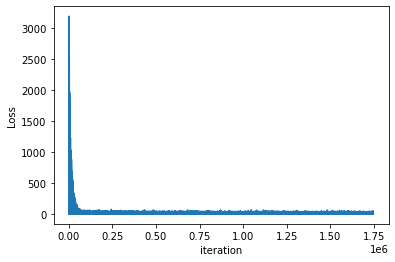

In [13]:
rnn = MyLSTM(device=device)
loss = []
criterion = nn.MSELoss()
opt = torch.optim.Adam(rnn.parameters(), lr=0.00005)
# n_epochs = 1000
n_epochs = 4
for e in tqdm(range(n_epochs)):
  print(f'epoch: {e}')
  for map_num in range(len(maps)):                                          # go through each map
    encoded_map = encoder(maps[map_num].unsqueeze(0).unsqueeze(0))
    for path_num in range(len(train_input_paths[map_num])):                # go through each path
      for point_num in range(len(train_input_paths[map_num][path_num])):   # go through each point

        # predict next point:
        pred = rnn(train_goal_points[map_num][path_num], train_input_paths[map_num][path_num][point_num], encoded_map).squeeze()

        # calculate loss:
        err = criterion(pred, train_target_paths[map_num][path_num][point_num])
        opt.zero_grad()
        err.backward(retain_graph=True)
        opt.step()

        loss.append(err.item())

        # # print loss:
        # if point_num % 100 == 0:  
        #   print(err.item())
    print(err.item())

plt.plot(loss)
plt.ylabel('Loss')
plt.xlabel('iteration')
plt.show()

In [14]:
SAVE_PATH = f"checkpoints/lstm/"

torch.save({
            'epoch': e,
            'model_state_dict': rnn.state_dict(),
            'optimizer_state_dict': opt.state_dict(),
            'loss': loss[len(loss)-1],
}, f"{SAVE_PATH}epoch-{e}.tar")

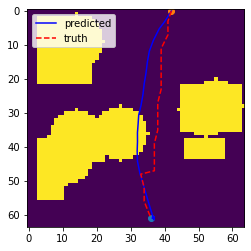

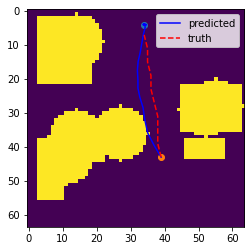

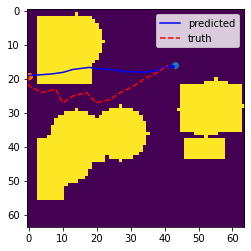

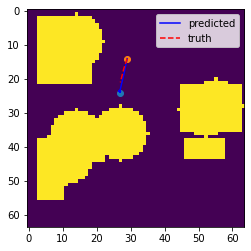

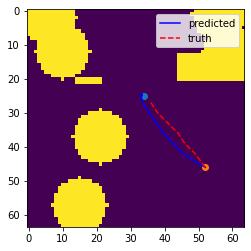

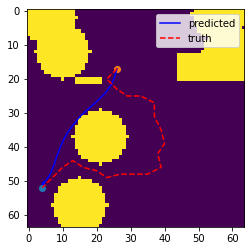

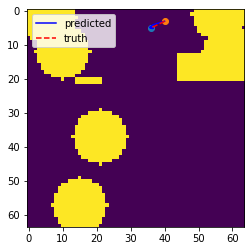

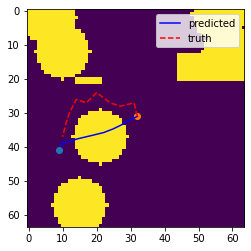

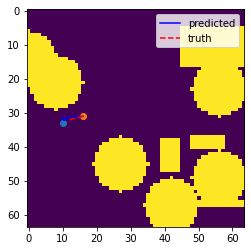

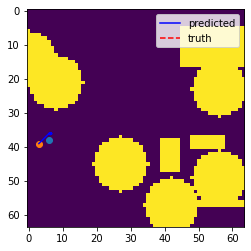

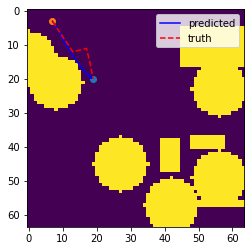

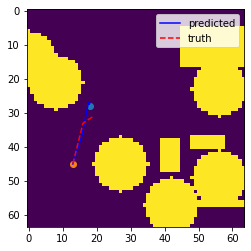

In [15]:
# testing to see if it follows paths used for training:

num_points = 30 # num points to predict for each path
maps_to_gen = 3
paths_to_gen = 4 # num training paths to plot

for map_idx in range(maps_to_gen):
    map = maps[map_idx]
    for path_idx in range(paths_to_gen):
        start_point = train_input_paths[map_idx][path_idx][0]
        generated_pts = []
        with torch.no_grad():
            
            # add start point:
            generated_pts.append(start_point.cpu().detach().numpy().tolist())
            prev_pred = start_point

            # predict other points:
            for i in range(num_points):
                pred = rnn(train_goal_points[map_idx][path_idx], prev_pred, encoded_map).squeeze()
                prev_pred = pred
                generated_pts.append(pred.cpu().detach().numpy().tolist())

        xs = []
        ys = []

        for x,y in generated_pts:
            xs.append(x)
            ys.append(y)

        plt.imshow(map.cpu())
        # plt.plot(xs, ys, color='k', label = "input")
        plt.plot(xs, ys, color='b', label = "predicted")
        plt.plot(train_input_paths[map_idx][path_idx][:,0].cpu(), train_input_paths[map_idx][path_idx][:,1].cpu(), color='r', label = "truth", linestyle='dashed')
        plt.scatter(train_goal_points[map_idx][path_idx][0].cpu(), train_goal_points[map_idx][path_idx][1].cpu())
        plt.scatter(start_point[0].cpu(), start_point[1].cpu())
        plt.legend()
        plt.show()

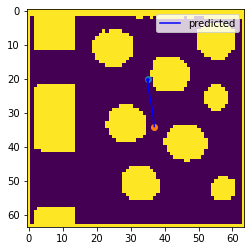

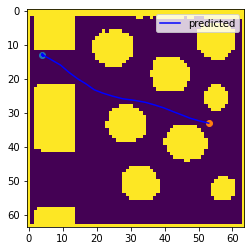

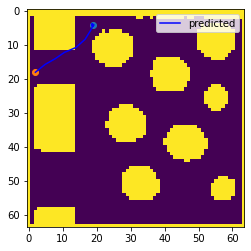

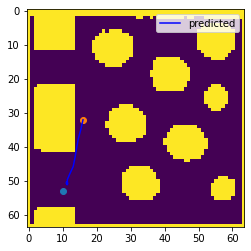

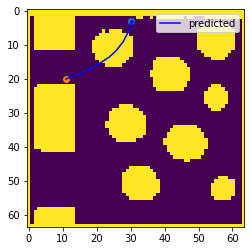

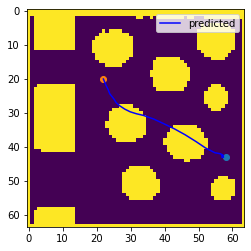

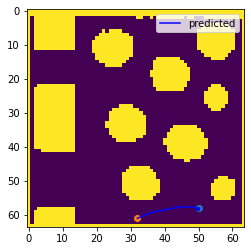

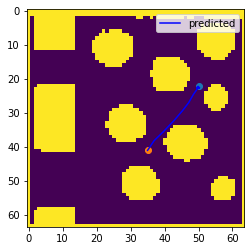

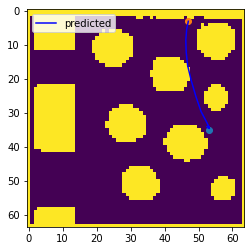

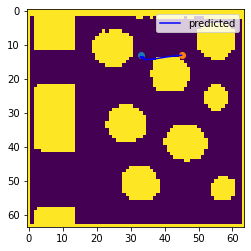

In [16]:
# load map lstm was not trained on:
flat_map = np.loadtxt(f"./env/{MAP_NAME}/{MAP_NAME}.txt", skiprows=2)                                                   # load in the flat path from file
map = torch.tensor(np.asarray(flat_map, dtype=int).reshape(MAP_SHAPE[0], MAP_SHAPE[1])).to(device, dtype=torch.float)     # unflatten the map from the file
map_4d = map.unsqueeze(0).unsqueeze(0)
encoded_map = encoder(map_4d)

# testing to see if it follows new paths:
non_obs_coords = np.transpose(torch.flipud(np.argwhere(map.cpu()==0)))
# print(non_obs_coords)

start_points_list = []
coords_list = []

num_points = 30 # num points to predict for each path
paths_to_gen = 10 # num paths to generate

for x in range(paths_to_gen):
    start_point = random.choice(non_obs_coords).float().to(device)
    goal_point = random.choice(non_obs_coords).float().to(device)

    points = []
    with torch.no_grad():
        pred = start_point
        points.append(pred.cpu().detach().numpy().tolist())
        for point in range(num_points):
            pred = rnn(goal_point, pred, encoded_map).squeeze()
            points.append(pred.cpu().detach().numpy().tolist())

    xs = []
    ys = []
    for x,y in points:
        xs.append(x)
        ys.append(y)

    plt.imshow(map.cpu())
    plt.plot(xs, ys, color='b', label = "predicted")
    plt.scatter(goal_point[0].cpu(), goal_point[1].cpu())
    plt.scatter(start_point[0].cpu(), start_point[1].cpu())
    plt.legend()
    plt.show()